# Analisis de bases de datos REDD

In [1]:
#Cargar las librerias para procesar los datos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import time
from tensorflow import keras
from tensorflow.keras import layers
import scipy
import statsmodels
import sklearn

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

## Base de datos low-frecuenty

In [4]:
from datetime import datetime
ts = int("1302930687")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S:%MS'))

2011-04-16 05:11:27:11S


In [5]:
ts = int("1302922280")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S:%MS'))

2011-04-16 02:51:20:51S


In [ ]:
1302930687
1302922280

In [4]:
directory = os.getcwd()
c1h1 = pd.read_csv(directory +'\low_freq\house_1\channel_1.dat',sep=r' ',encoding='utf-8',header=None)

In [5]:
c1h1.head()

,0,1
0,1303132929,224.19
1,1303132930,225.57
2,1303132931,226.09
3,1303132932,222.74
4,1303132933,222.20


Cambio el formato de la columna 0 de tiempo UTC Unix a Date

In [6]:
ts = []
for i in c1h1[0]:
    ts.append(pd.to_datetime(i,unit='s'))

In [7]:
c1h1['2'] = ts

In [9]:
c1h1['2'].axes

[RangeIndex(start=0, stop=1561660, step=1)]

In [10]:
c1h1.to_csv('c1h1.csv')

In [11]:
x1 = c1h1['2']
y1 = c1h1[1]

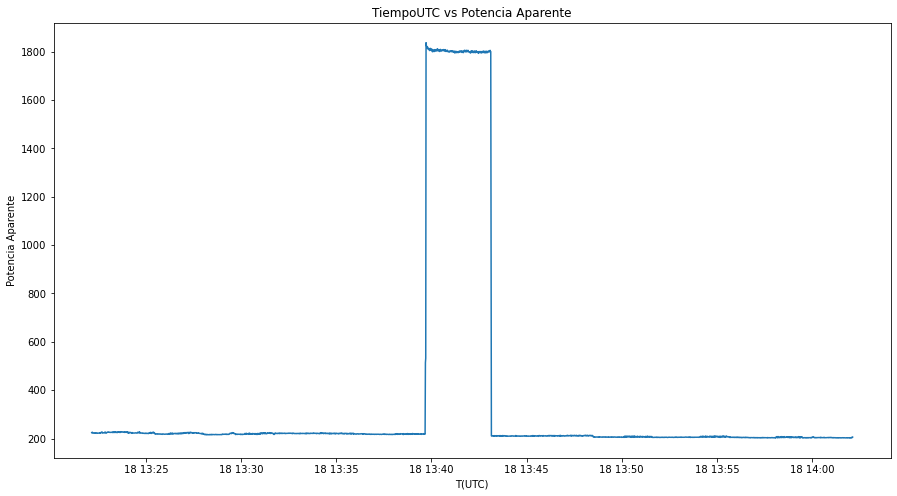

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(x1[:2400],y1[:2400])

plt.xlabel('T(UTC)')
plt.ylabel('Potencia Aparente')
plt.title('TiempoUTC vs Potencia Aparente')
plt.show()

In [13]:
x2 = c1h1[0]
y2 = c1h1[1]

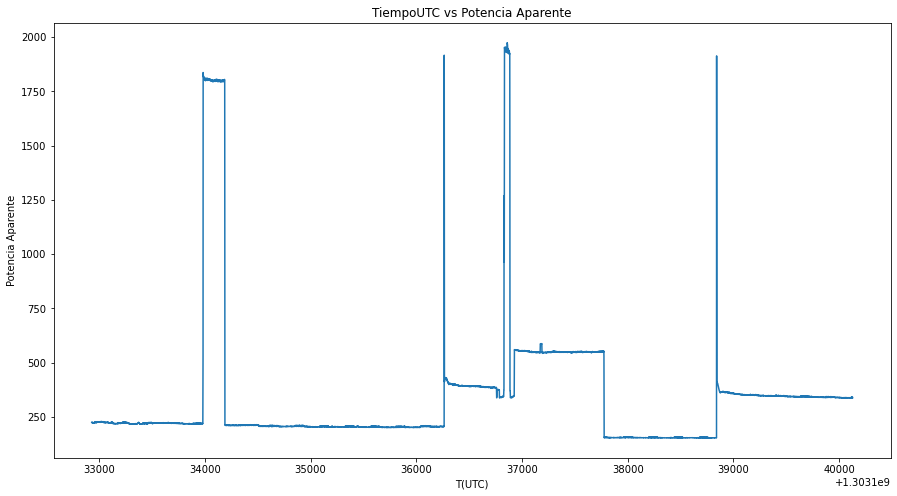

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(x2[:7200],y2[:7200])

plt.xlabel('T(UTC)')
plt.ylabel('Potencia Aparente')
plt.title('TiempoUTC vs Potencia Aparente')
plt.show()

In [15]:
c1h12 = pd.read_csv('c1h1.csv',sep=r',',encoding='utf-8')

In [16]:
c1h12.head()

,Unnamed: 0,0,1,2
0,0,1303132929,224.19,2011-04-18 13:22:09
1,1,1303132930,225.57,2011-04-18 13:22:10
2,2,1303132931,226.09,2011-04-18 13:22:11
3,3,1303132932,222.74,2011-04-18 13:22:12
4,4,1303132933,222.20,2011-04-18 13:22:13


In [17]:
np.shape(c1h12)

(1561660, 4)

In [18]:
type(c1h12['2'])

pandas.core.series.Series

## Analisis de datos alta frecuencia high_freq 

El directorio high_freq / contiene datos de forma de onda de CA para la red eléctrica y una sola fase del voltaje para el hogar. Para reducir los datos a un tamaño manejable, hemos comprimido estas formas de onda usando compresión con pérdida. Brevemente, el procedimiento es el siguiente:

- Debido a que la señal de voltaje en la mayoría de los hogares es aproximadamente sinusoidal (a diferencia de las señales de corriente, que pueden variar sustancialmente de una onda sinusoidal), encontramos cruces por cero de la señal de voltaje para aislar un solo ciclo de la energía de CA. Durante el tiempo que abarca este ciclo único, registramos tanto las señales de corriente como las de voltaje, e informamos esta forma de onda completa. Sin embargo, debido a que las formas de onda permanecen aproximadamente constantes durante largos períodos de tiempo, solo informamos las formas de onda de corriente y voltaje en los "puntos de cambio" de la señal (identificamos los puntos de cambio utilizando un método conocido como regularización de variación total, pero una descripción completa del enfoque está fuera del alcance de este archivo 

Cada archivo contiene
1. Una marca de tiempo UTC decimal, en el mismo formato que las marcas de tiempo para los datos de baja frecuencia, pero permitiendo partes fraccionarias
2. Un recuento de ciclos. Aunque esto se representa en el archivo como un doble, de hecho es un número entero que indica cuántos ciclos de CA permanece esta forma de onda en particular.
3. 275 valores decimales, que indican el valor de la forma de onda (en amperios o voltios), en partes igualmente espaciadas del ciclo.

- Por tanto, un archivo de ejemplo podría ser:

1297340206.597013 135.000000 0.000000 3.623859 7.254136 10.949398 ...
1297340208.844086 722.000000 0.000000 3.638527 7.249567 10.929027 ...
....

- Indica que la forma de onda en la primera línea ocurrió primero en la marca de tiempo 1297340206.597013 y duró 135 ciclos.


### Cargar los datos
En este se tienen cinco registros de cambios en la red electrica para la casa 3. Para su análisis se procede según los siguientes criterios:
1. Cargar los datos para corriente 1, 2 y voltage
2. Aislar las formas de ondas captadas de las columnas 0 y 1 correspondiente al numero de ciclos de CA que permanece la forma de onda registrada
3. Graficar los datos para cada evento. 

### Casa 3

In [19]:
hfc1h3 = pd.read_csv(directory +'\high_freq\house_3\current_1.dat', sep=r' ',encoding='utf-8',header=None) #Corriente 1
hfc2h3 = pd.read_csv(directory +'\high_freq\house_3\current_2.dat', sep=r' ',encoding='utf-8',header=None) #Corriente 2
hfvh3 = pd.read_csv(directory +'\high_freq\house_3\Voltage.dat', sep=r' ',encoding='utf-8',header=None) # Voltaje

In [20]:
hfc1h3.head()

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.302922e+09,1782.0,-0.017231,-0.017167,-0.017059,-0.017008,-0.017104,-0.017163,-0.017450,-0.017587,...,-0.017431,-0.017421,-0.017433,-0.017398,-0.017257,-0.017344,-0.017262,-0.017277,-0.017192,-0.017232
1,1.302922e+09,1782.0,-0.017288,-0.017300,-0.017320,-0.017308,-0.017248,-0.017345,-0.017636,-0.017700,...,-0.017539,-0.017615,-0.017604,-0.017637,-0.017505,-0.017600,-0.017512,-0.017387,-0.017450,-0.017289
2,1.302931e+09,2760.0,0.002427,0.007893,0.020264,0.037044,0.059954,0.139391,0.195261,0.231653,...,-0.131324,-0.208694,-0.192772,-0.104762,-0.070186,-0.036816,-0.027137,-0.012471,-0.003119,0.002425
3,1.302931e+09,2065.0,0.004701,0.008471,0.022125,0.040235,0.063376,0.143110,0.198713,0.237631,...,-0.131911,-0.212030,-0.197415,-0.107624,-0.073997,-0.036811,-0.027118,-0.013915,-0.003341,0.004708
4,1.302931e+09,206.0,0.002921,0.006746,0.021267,0.042351,0.065329,0.144688,0.197718,0.238668,...,-0.216036,-0.261511,-0.158430,-0.126622,-0.074224,-0.036602,-0.027803,-0.014041,-0.005268,0.002964


In [21]:
hfc2h3.head()

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.302922e+09,1782.0,0.013275,0.013257,0.013399,0.013447,0.013479,0.013486,0.013211,0.013200,...,0.012846,0.012910,0.012914,0.013005,0.013098,0.013110,0.013095,0.013255,0.013161,0.013273
1,1.302922e+09,1782.0,0.012948,0.013030,0.012970,0.013087,0.013138,0.013141,0.012844,0.012700,...,0.012454,0.012526,0.012457,0.012624,0.012727,0.012608,0.012772,0.012820,0.012769,0.012948
2,1.302931e+09,2760.0,0.010864,0.077678,0.134422,0.190032,0.240667,0.288123,0.330805,0.373830,...,-0.985296,-0.875025,-0.762005,-0.647368,-0.531156,-0.415636,-0.301972,-0.191778,-0.084063,0.010859
3,1.302931e+09,5830.0,0.021219,0.085437,0.138456,0.192836,0.240279,0.286005,0.326347,0.367732,...,-0.960882,-0.850368,-0.738046,-0.624154,-0.508765,-0.395841,-0.284780,-0.176203,-0.070746,0.021222
4,1.302931e+09,2187.0,0.027409,0.090737,0.142872,0.196044,0.242590,0.285997,0.326040,0.365007,...,-0.954011,-0.843179,-0.730964,-0.616255,-0.500366,-0.387588,-0.276184,-0.169143,-0.064239,0.027411


In [22]:
hfvh3.head()

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.302922e+09,135.0,0.0,3.969017,7.902928,11.751840,15.418762,18.961458,22.539339,26.137636,...,-36.037585,-32.000332,-28.111060,-24.210287,-20.220139,-16.171227,-12.096537,-8.050400,-4.008538,0.0
1,1.302922e+09,1009.0,-0.0,3.962783,7.908012,11.730148,15.362362,18.895726,22.474943,26.070390,...,-36.029062,-31.966137,-28.069801,-24.140646,-20.124381,-16.085305,-12.039245,-8.017876,-3.990100,-0.0
2,1.302922e+09,275.0,0.0,3.953840,7.877722,11.687472,15.312901,18.839730,22.405798,25.988117,...,-36.103393,-32.049191,-28.152667,-24.189949,-20.154935,-16.121525,-12.057003,-8.018223,-3.984467,0.0
3,1.302922e+09,363.0,-0.0,3.951436,7.862298,11.678304,15.312730,18.839642,22.403130,26.001974,...,-36.114037,-32.014917,-28.121589,-24.203373,-20.171653,-16.113385,-12.043114,-8.013200,-3.983908,-0.0
4,1.302922e+09,464.0,0.0,3.955547,7.876902,11.683715,15.311048,18.836016,22.395011,25.980069,...,-36.037455,-31.968391,-28.097778,-24.179424,-20.155325,-16.114571,-12.049510,-8.015634,-3.983801,0.0


### Análisis para los eventos casa 3
Primero segmentamos la información para cada evento detectado en las tres variables

In [23]:
#Evento cero 0
c1_0 = hfc1h3.iloc[0,2:] #Corriente 1
c2_0 = hfc2h3.iloc[0,2:] #Corriente 2
v_0 = hfvh3.iloc[0,2:] #Voltaje
#Evento uno 1
c1_1 = hfc1h3.iloc[1,2:] #Corriente 1
c2_1 = hfc2h3.iloc[1,2:] #Corriente 2
v_1 = hfvh3.iloc[1,2:] #Voltaje
#Evento dos 2
c1_2 = hfc1h3.iloc[2,2:] #Corriente 1
c2_2 = hfc2h3.iloc[2,2:] #Corriente 2
v_2 = hfvh3.iloc[2,2:] #Voltaje
#Evento tres 3
c1_3 = hfc1h3.iloc[3,2:] #Corriente 1
c2_3 = hfc2h3.iloc[3,2:] #Corriente 2
v_3 = hfvh3.iloc[3,2:] #Voltaje
#Evento cuatro 4
c1_4 = hfc1h3.iloc[4,2:] #Corriente 1
c2_4 = hfc2h3.iloc[4,2:] #Corriente 2
v_4 = hfvh3.iloc[4,2:] #Voltaje

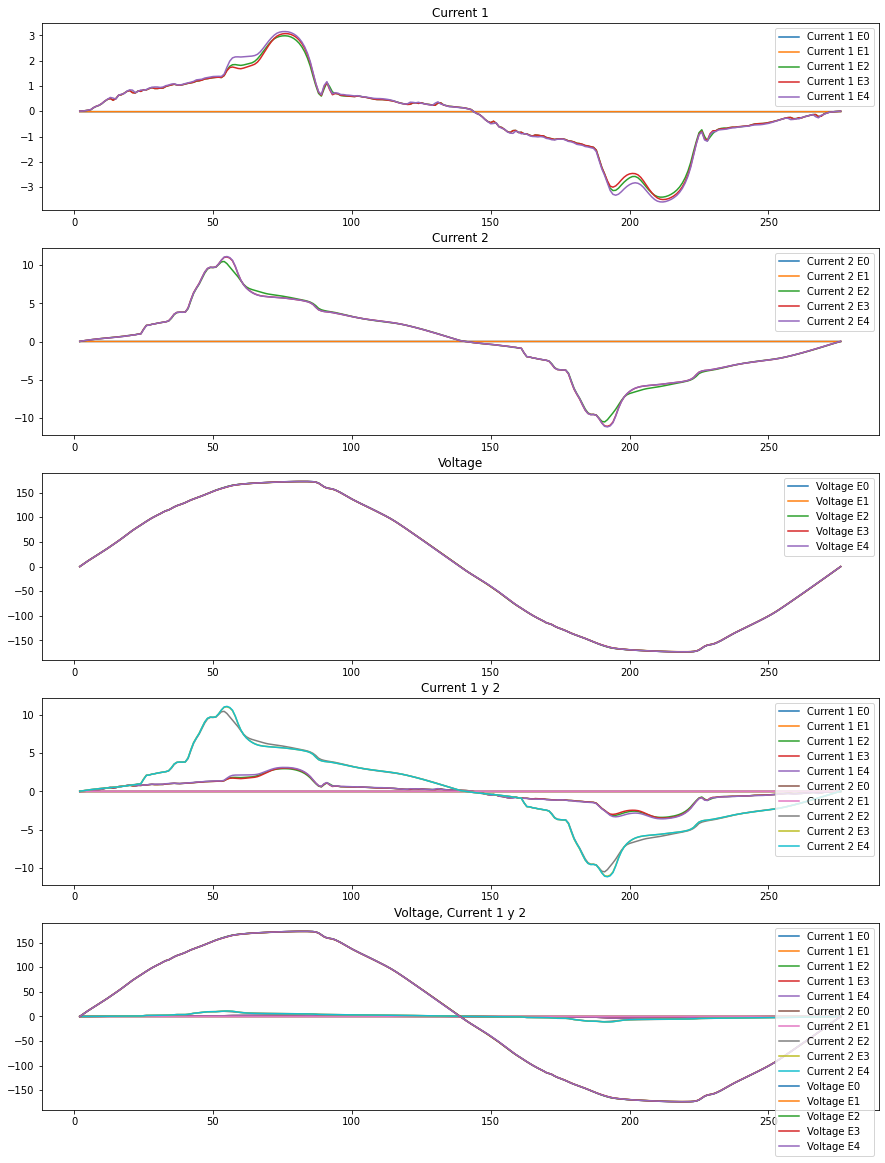

In [24]:
plt.figure(figsize=(15,20))
#Corriente 1
plt.subplot(5,1,1)
plt.plot(c1_0, label="Current 1 E0")
plt.plot(c1_1, label="Current 1 E1")
plt.plot(c1_2, label="Current 1 E2")
plt.plot(c1_3, label="Current 1 E3")
plt.plot(c1_4, label="Current 1 E4")
plt.title('Current 1')
plt.legend()
#Corriente 2
plt.subplot(5,1,2)
plt.plot(c2_0, label="Current 2 E0")
plt.plot(c2_1, label="Current 2 E1")
plt.plot(c2_2, label="Current 2 E2")
plt.plot(c2_3, label="Current 2 E3")
plt.plot(c2_4, label="Current 2 E4")
plt.title('Current 2')
plt.legend()
#Voltaje
plt.subplot(5,1,3)
plt.plot(v_0, label="Voltage E0")
plt.plot(v_1, label="Voltage E1")
plt.plot(v_2, label="Voltage E2")
plt.plot(v_3, label="Voltage E3")
plt.plot(v_4, label="Voltage E4")
plt.title('Voltage')
plt.legend()
#Corriente 1 y 2
plt.subplot(5,1,4)
plt.plot(c1_0, label="Current 1 E0")
plt.plot(c1_1, label="Current 1 E1")
plt.plot(c1_2, label="Current 1 E2")
plt.plot(c1_3, label="Current 1 E3")
plt.plot(c1_4, label="Current 1 E4")

plt.plot(c2_0, label="Current 2 E0")
plt.plot(c2_1, label="Current 2 E1")
plt.plot(c2_2, label="Current 2 E2")
plt.plot(c2_3, label="Current 2 E3")
plt.plot(c2_4, label="Current 2 E4")
plt.title('Current 1 y 2')
plt.legend()
#Corriente 1, 2 y voltage
plt.subplot(5,1,5)
plt.plot(c1_0, label="Current 1 E0")
plt.plot(c1_1, label="Current 1 E1")
plt.plot(c1_2, label="Current 1 E2")
plt.plot(c1_3, label="Current 1 E3")
plt.plot(c1_4, label="Current 1 E4")

plt.plot(c2_0, label="Current 2 E0")
plt.plot(c2_1, label="Current 2 E1")
plt.plot(c2_2, label="Current 2 E2")
plt.plot(c2_3, label="Current 2 E3")
plt.plot(c2_4, label="Current 2 E4")

plt.plot(v_0, label="Voltage E0")
plt.plot(v_1, label="Voltage E1")
plt.plot(v_2, label="Voltage E2")
plt.plot(v_3, label="Voltage E3")
plt.plot(v_4, label="Voltage E4")
plt.title('Voltage, Current 1 y 2')
plt.legend()

### Casa 5

In [25]:
hfc1h3 = pd.read_csv(directory +'\high_freq\house_5\current_1.dat', sep=r' ',encoding='utf-8',header=None) #Corriente 1
hfc2h3 = pd.read_csv(directory +'\high_freq\house_5\current_2.dat', sep=r' ',encoding='utf-8',header=None) #Corriente 2
hfvh3 = pd.read_csv(directory +'\high_freq\house_5\Voltage.dat', sep=r' ',encoding='utf-8',header=None) # Voltaje

In [26]:
hfc1h3.head()

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.303101e+09,14366.0,0.307745,0.299123,0.288489,0.270551,0.257409,0.246582,0.234549,0.217508,...,0.329277,0.329541,0.325082,0.320891,0.313777,0.315375,0.314324,0.312496,0.312495,0.307743
1,1.303101e+09,2037.0,0.305608,0.296932,0.286762,0.268409,0.255680,0.244235,0.232156,0.214678,...,0.325625,0.325432,0.320537,0.315938,0.310283,0.312394,0.311909,0.309330,0.309590,0.305612
2,1.303101e+09,4877.0,0.303696,0.294618,0.283828,0.266173,0.252728,0.241913,0.229488,0.212179,...,0.324958,0.325572,0.319852,0.315829,0.309364,0.311667,0.310260,0.308529,0.308789,0.303696
3,1.303101e+09,4321.0,0.299805,0.290570,0.279848,0.261977,0.248834,0.239498,0.225689,0.212200,...,0.319706,0.318795,0.315455,0.309474,0.304645,0.306929,0.306095,0.304453,0.304251,0.299803
4,1.303101e+09,3123.0,0.297964,0.289466,0.278913,0.259247,0.245368,0.236856,0.221391,0.209251,...,0.322164,0.320979,0.317370,0.311540,0.305946,0.308073,0.306781,0.304565,0.303755,0.297976


In [27]:
hfc2h3.head()

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.303101e+09,2200.0,-0.168824,-0.154634,-0.135127,-0.107669,-0.086549,-0.067596,-0.026074,0.025922,...,-0.335513,-0.311717,-0.313324,-0.302635,-0.286612,-0.262460,-0.231943,-0.205189,-0.183612,-0.168813
1,1.303101e+09,1.0,-0.114265,-0.101635,-0.076715,-0.057600,-0.044254,-0.015913,0.024283,0.063900,...,0.555634,0.561212,0.486226,0.505892,0.476935,0.486155,0.517741,0.517718,0.486146,0.499944
2,1.303101e+09,12165.0,0.546111,0.532272,0.522337,0.521503,0.513515,0.503073,0.513933,0.536489,...,0.582081,0.586690,0.564101,0.555418,0.551640,0.552969,0.559547,0.561458,0.557093,0.546116
3,1.303101e+09,5695.0,0.545929,0.532415,0.521964,0.521351,0.514047,0.504064,0.514250,0.537881,...,0.583108,0.587740,0.565198,0.555045,0.551111,0.551562,0.557282,0.559681,0.556736,0.545930
4,1.303101e+09,8663.0,0.556852,0.544072,0.537348,0.538842,0.527718,0.519688,0.533643,0.555856,...,0.590762,0.590048,0.565558,0.558563,0.557546,0.562571,0.568004,0.569859,0.565954,0.556851


In [28]:
hfvh3.head()

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.303101e+09,676.0,-0.0,3.744206,7.455309,11.222042,15.031137,18.783999,22.461282,26.117716,...,-36.172836,-32.198408,-28.168782,-24.073342,-19.886533,-15.721416,-11.646643,-7.661296,-3.778537,-0.0
1,1.303101e+09,724.0,0.0,3.731381,7.434775,11.203264,14.999385,18.739581,22.403087,26.051571,...,-36.152641,-32.189487,-28.165060,-24.073455,-19.885758,-15.715576,-11.644186,-7.660237,-3.780118,0.0
2,1.303101e+09,1111.0,-0.0,3.759215,7.484881,11.284153,15.119484,18.897790,22.596028,26.286342,...,-36.082253,-32.146873,-28.133595,-24.056196,-19.874663,-15.719999,-11.659781,-7.673830,-3.794343,-0.0
3,1.303101e+09,1895.0,-0.0,3.736399,7.449795,11.235165,15.045123,18.798561,22.452799,26.080493,...,-36.165576,-32.199885,-28.161914,-24.046418,-19.841083,-15.687910,-11.630476,-7.649583,-3.777869,-0.0
4,1.303101e+09,364.0,0.0,3.718899,7.384370,11.108508,14.876646,18.596114,22.230560,25.867705,...,-36.133060,-32.159668,-28.110149,-24.012653,-19.833239,-15.671614,-11.609029,-7.626034,-3.759626,0.0


### Análisis para los eventos casa 5
Primero segmentamos la información para cada evento detectado en las tres variables

In [29]:
#Evento cero 0
c1_0 = hfc1h3.iloc[0,2:] #Corriente 1
c2_0 = hfc2h3.iloc[0,2:] #Corriente 2
v_0 = hfvh3.iloc[0,2:] #Voltaje
#Evento uno 1
c1_1 = hfc1h3.iloc[1,2:] #Corriente 1
c2_1 = hfc2h3.iloc[1,2:] #Corriente 2
v_1 = hfvh3.iloc[1,2:] #Voltaje
#Evento dos 2
c1_2 = hfc1h3.iloc[2,2:] #Corriente 1
c2_2 = hfc2h3.iloc[2,2:] #Corriente 2
v_2 = hfvh3.iloc[2,2:] #Voltaje
#Evento tres 3
c1_3 = hfc1h3.iloc[3,2:] #Corriente 1
c2_3 = hfc2h3.iloc[3,2:] #Corriente 2
v_3 = hfvh3.iloc[3,2:] #Voltaje
#Evento cuatro 4
c1_4 = hfc1h3.iloc[4,2:] #Corriente 1
c2_4 = hfc2h3.iloc[4,2:] #Corriente 2
v_4 = hfvh3.iloc[4,2:] #Voltaje

### Graficamos los eventos

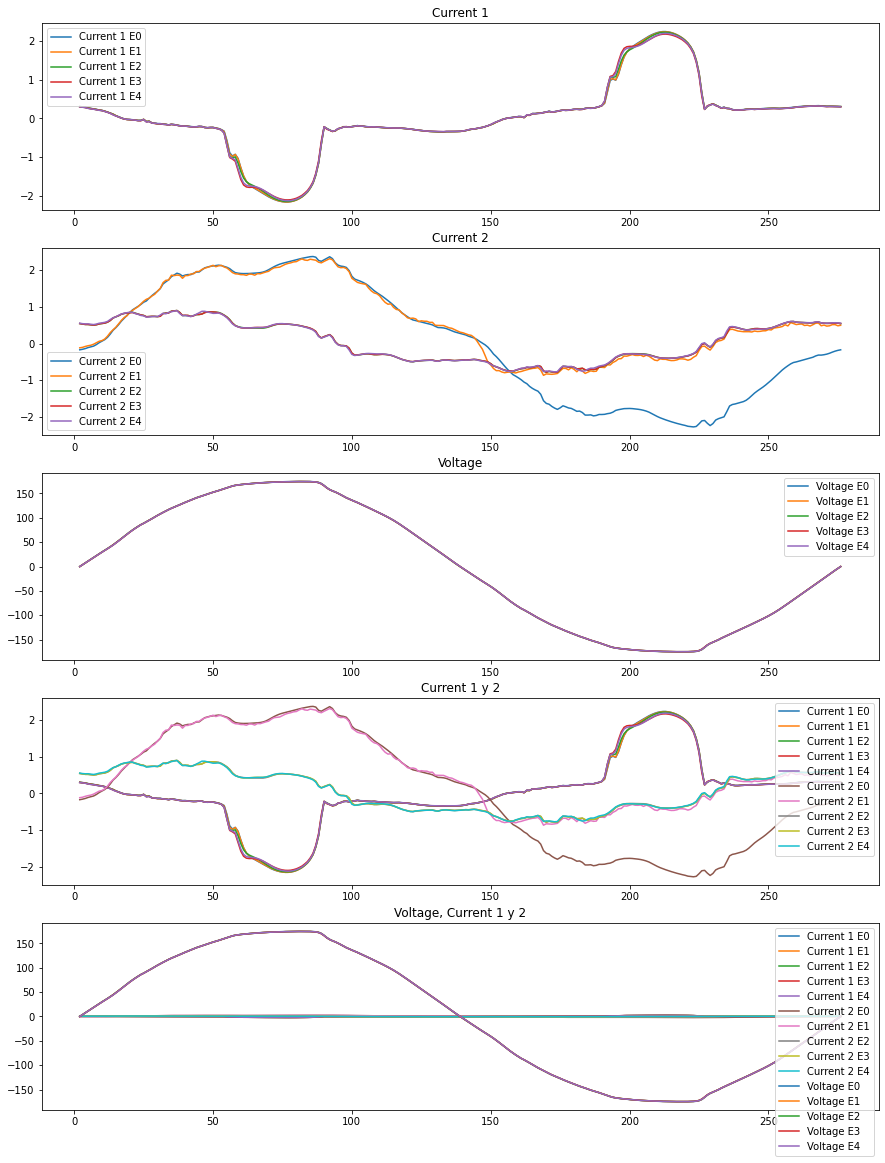

In [30]:
plt.figure(figsize=(15,20))
#Corriente 1
plt.subplot(5,1,1)
plt.plot(c1_0, label="Current 1 E0")
plt.plot(c1_1, label="Current 1 E1")
plt.plot(c1_2, label="Current 1 E2")
plt.plot(c1_3, label="Current 1 E3")
plt.plot(c1_4, label="Current 1 E4")
plt.title('Current 1')
plt.legend()
#Corriente 2
plt.subplot(5,1,2)
plt.plot(c2_0, label="Current 2 E0")
plt.plot(c2_1, label="Current 2 E1")
plt.plot(c2_2, label="Current 2 E2")
plt.plot(c2_3, label="Current 2 E3")
plt.plot(c2_4, label="Current 2 E4")
plt.title('Current 2')
plt.legend()
#Voltaje
plt.subplot(5,1,3)
plt.plot(v_0, label="Voltage E0")
plt.plot(v_1, label="Voltage E1")
plt.plot(v_2, label="Voltage E2")
plt.plot(v_3, label="Voltage E3")
plt.plot(v_4, label="Voltage E4")
plt.title('Voltage')
plt.legend()
#Corriente 1 y 2
plt.subplot(5,1,4)
plt.plot(c1_0, label="Current 1 E0")
plt.plot(c1_1, label="Current 1 E1")
plt.plot(c1_2, label="Current 1 E2")
plt.plot(c1_3, label="Current 1 E3")
plt.plot(c1_4, label="Current 1 E4")

plt.plot(c2_0, label="Current 2 E0")
plt.plot(c2_1, label="Current 2 E1")
plt.plot(c2_2, label="Current 2 E2")
plt.plot(c2_3, label="Current 2 E3")
plt.plot(c2_4, label="Current 2 E4")
plt.title('Current 1 y 2')
plt.legend()
#Corriente 1, 2 y voltage
plt.subplot(5,1,5)
plt.plot(c1_0, label="Current 1 E0")
plt.plot(c1_1, label="Current 1 E1")
plt.plot(c1_2, label="Current 1 E2")
plt.plot(c1_3, label="Current 1 E3")
plt.plot(c1_4, label="Current 1 E4")

plt.plot(c2_0, label="Current 2 E0")
plt.plot(c2_1, label="Current 2 E1")
plt.plot(c2_2, label="Current 2 E2")
plt.plot(c2_3, label="Current 2 E3")
plt.plot(c2_4, label="Current 2 E4")

plt.plot(v_0, label="Voltage E0")
plt.plot(v_1, label="Voltage E1")
plt.plot(v_2, label="Voltage E2")
plt.plot(v_3, label="Voltage E3")
plt.plot(v_4, label="Voltage E4")
plt.title('Voltage, Current 1 y 2')
plt.legend()

In [31]:
#from datetime import datetime
#ts = float("1297340206.597013")
#date = datetime.fromtimestamp(ts)
#print(date)

In [32]:
#pd.to_datetime('1297340206.597013', errors='ignore', unit='s')

## Análisis en alta frecuencia high_freq_raw
Contiene formas de onda de corriente y voltaje sin procesar (no alineadas y sin compresión), para una pequeña cantidad de puntos de muestra a lo largo de los datos. Esto está destinado principalmente a aquellos que desean probar diferentes métodos de compresión / filtrado más allá de lo que hacemos en high_freq / data. Aunque por razones prácticas no estamos planeando distribuir ampliamente los datos sin procesar para todo el conjunto de datos (esto consistiría en más de un terabyte de datos), si otros grupos pueden desarrollar técnicas de compresión / filtrado sustancialmente mejores, estaremos encantados de comparta los datos completos o ejecute estos algoritmos propuestos en el conjunto de datos completo sin comprimir.

El directorio high_freq_raw / está organizado de manera similar al directorio high_freq /, excepto que cada archivo current_1, current_2 y voltage son en su lugar directorios que contienen datos binarios sin procesar:

high_freq_raw /
  house_ {1..n} / - directorios para cada casa
    current_1 / - formas de onda de corriente para la primera red eléctrica
      <marca de tiempo> .bz2: datos binarios comprimidos
      ...
    current_2 / - formas de onda de corriente para la segunda red eléctrica
    voltaje / - formas de onda de voltaje

Los directorios current_1 /, current_2 / y voltage / contienen varios archivos <timestamp> .bz2, por ejemplo 1303091049.bz2. Estos son archivos binarios comprimidos que contienen las formas de onda de corriente / voltaje sin procesar del A / D como una secuencia de números de coma flotante de 32 bits (almacenados en formato little-endian). Intercalados a través de los datos hay varios códigos ASCII de 'tiempo' (hexadecimal: 0x74 0x69 0x6d 0x65). Esto indica que le seguirá un código de tiempo de 8 bytes, que indica el tiempo al comienzo de la muestra. El tiempo se almacena como dos enteros binarios (nuevamente en formato little endian): el primero indica la marca de tiempo UTC en segundos y el segundo indica la parte fraccionaria de la marca de tiempo en nanosegundos. Las marcas de tiempo se toman utilizando el reloj de Windows en las máquinas recolectoras, por lo que es probable que solo tengan una precisión de milisegundos más o menos.

## Cargar los datos 

Verificar el tipo de extension de los archivos comprimidos

In [33]:
import sys
import os
import bz2
from bz2 import decompress
import io
#directory = os.getcwd()
os.chdir(directory +'\\high_freq_raw\\house_3\\current_1')
paquetes = os.listdir()
print(paquetes)

['1303091049.bz2', '1303091049.txt', '1303091288.bz2', '1303091288.txt', '1303091528.bz2', '1303091528.txt', '1303091767.bz2', '1303091767.txt', '1303092006.bz2', '1303092006.txt', '1303092246.bz2', '1303092246.txt', '1303092485.bz2', '1303092485.txt', '1303092725.bz2', '1303092725.txt', '1303092964.bz2', '1303092964.txt', '1303093203.bz2', '1303093203.txt', '1303093443.bz2', '1303093443.txt', '1303093682.bz2', '1303093682.txt', '1303093922.bz2', '1303093922.txt', '1303094161.bz2', '1303094161.txt', '1303094401.bz2', '1303094401.txt', '1303094640.bz2', '1303094640.txt', '1303094879.bz2', '1303094879.txt', '1303095119.bz2', '1303095119.txt', '1303095358.bz2', '1303095358.txt', '1303095598.bz2', '1303095598.txt', '1303095837.bz2', '1303095837.txt']


Descomprimir los archivos de formato bz2 a txt

In [34]:
path = 'C:\\Users\\josel\\REDD_Pruebas\\high_freq_raw\\house_3\current_1\\'
directory2 = os.getcwd()
for paquete in paquetes:
    direccion_entrada = path + paquete
    print(direccion_entrada)
    nombre_salida =  paquete[:-4] + '.txt'
    
    f_in = open(direccion_entrada, "rb") #Lectura archivo de entrada
    f_out = open(nombre_salida, "wb") #Nombre y extensión archivo de salida
    f_out.write(bz2.decompress(f_in.read())) #Guardar el archivo
    f_out.close() #Cerrar el archivo de salida en la memoria 
    f_in.close() #Cerrar el archivo de entrada en la memoria
    

C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091049.bz2
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091049.txt
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091288.bz2
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091288.txt
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091528.bz2
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091528.txt
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091767.bz2
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303091767.txt
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303092006.bz2
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303092006.txt
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303092246.bz2
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303092246.txt
C:\Users\josel\REDD_Pruebas\high_freq_raw\house_3\current_1\1303092485.bz2
C:\Users\josel\REDD_Prueb

In [35]:
hfrc1h3 = pd.read_csv(directory +'\high_freq_raw\ house_3\current_1\\1303091049.txt') #Corriente 1
#hfrc2h3 = pd.read_csv(directory +'\high_freq_raw\ house_3\current_2.dat', sep=r' ',encoding='utf-8',header=None) #Corriente 2
#hfrvh3 = pd.read_csv(directory +'\high_freq_raw\ house_3\Voltage.dat', sep=r' ',encoding='utf-8',header=None) # Voltaje

FileNotFoundError: [Errno 2] File C:\Users\josel\REDD_Pruebas\high_freq_raw\ house_3\current_1\1303091049.txt does not exist: 'C:\\Users\\josel\\REDD_Pruebas\\high_freq_raw\\ house_3\\current_1\\1303091049.txt'